In [1]:
from keras.utils import normalize
from unet_model import multi_unet_model
from unet512 import unet
import os
import glob
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

2024-10-15 06:46:22.648511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 06:46:22.764747: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 06:46:22.801872: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 06:46:22.996259: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define constants
SIZE_X = 256 
SIZE_Y = 256
n_classes = 13  # Number of classes for segmentation

# Capture training image info as a list
train_images = []
for directory_path in glob.glob("version/training/combined rgb/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)  # Read as grayscale
        train_images.append(img)
        
# Convert list to array for machine learning processing
train_images = np.array(train_images)

# Capture mask/label info as a list
train_masks = []
for directory_path in glob.glob("version/training/combined masked/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)  # Read mask as grayscale
        train_masks.append(mask)
        
# Convert list to array for machine learning processing
train_masks = np.array(train_masks)

In [3]:
# n, h, w = train_masks.shape  # Get shape of the mask data
# train_masks_reshaped = train_masks.reshape(-1, 1)  # Flatten the mask to a 2D array

# # Initialize and apply label encoder
# labelencoder = LabelEncoder()

# # Fit label encoder and transform mask values to sequential integers
# train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)

# # Reshape back to the original mask shape
# train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

# # Check unique labels
# unique_labels = np.unique(train_masks_encoded_original_shape)
# print("Unique labels in the encoded mask:", unique_labels)

# # Print the mapping of original pixel values to encoded labels
# print("Label mapping:")
# for original, encoded in zip(labelencoder.classes_, range(len(labelencoder.classes_))):
#     print(f"Original value {original} -> Encoded label {encoded}")

train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

# train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [4]:
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

Class values in the dataset are ...  [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


In [5]:
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(train_masks_reshaped_encoded),
#                                                  train_masks_reshaped_encoded)
# print("Class weights are...:", class_weights)


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

def get_model2():
    return unet(n_class=n_classes, input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

model = get_model2()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')



I0000 00:00:1728956798.268377    4375 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728956798.368384    4375 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728956798.368690    4375 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728956798.373546    4375 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[

 Total params: 3,111,469 (11.87 MB)

 Trainable params: 3,108,525 (11.86 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [6]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=39, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)
                    


# model.save('test.hdf5')

2024-10-15 06:48:18.334065: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1151860736 exceeds 10% of free system memory.
2024-10-15 06:48:19.659605: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1151860736 exceeds 10% of free system memory.


Epoch 1/39


I0000 00:00:1728956910.985169    4512 service.cc:146] XLA service 0x725b2c002690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728956910.985266    4512 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2024-10-15 06:48:31.296192: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-15 06:48:32.790006: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-15 06:49:06.990257: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_13', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Reg

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.5902 - loss: 1.6017

2024-10-15 06:49:43.705769: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_13', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_10', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_11', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_14', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in funct

43/43 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.5928 - loss: 1.5889 - val_accuracy: 0.7495 - val_loss: 1.7493
Epoch 2/39
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 430ms/step - accuracy: 0.7695 - loss: 0.6708 - val_accuracy: 0.7495 - val_loss: 4.6680
Epoch 3/39
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 430ms/step - accuracy: 0.8245 - loss: 0.4917 - val_accuracy: 0.7495 - val_loss: 4.4147
Epoch 4/39
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 472ms/step - accuracy: 0.8752 - loss: 0.3418 - val_accuracy: 0.7495 - val_loss: 6.8780
Epoch 5/39
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 587ms/step - accuracy: 0.9014 - loss: 0.2787 - val_accuracy: 0.7495 - val_loss: 6.2106
Epoch 6/39
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 586ms/step - accuracy: 0.9248 - loss: 0.2242 - val_accuracy: 0.7494 - val_loss: 6.3705
Epoch 7/39
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 586ms/step - accuracy: 0.9357 - loss: 0.1893 - val_accuracy: 0.7493 - val_loss: 6.2316
Epoch 8/39
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 586ms/step - accuracy: 0.9473 - loss: 0.1534 - val_accuracy: 0.7462 

In [7]:
model.save('unet512_256_256_grey_combined_50epochs_9790acc.hdf5')

In [9]:
# AFTER TRAINING

(256, 256, 1)
(1, 256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


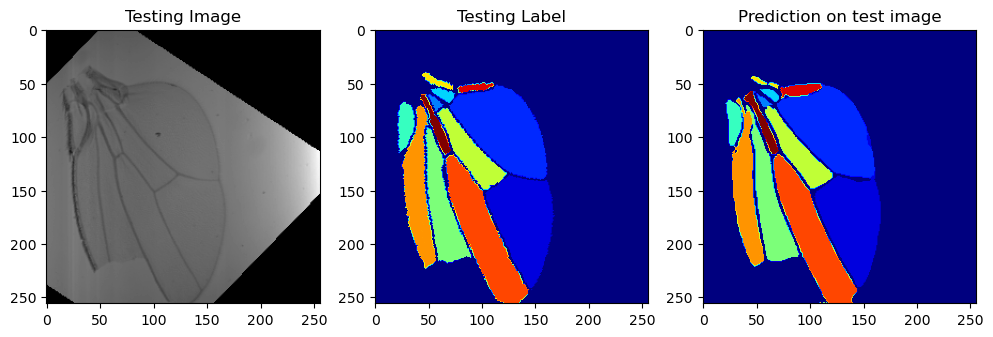

In [62]:


# model = get_model()


# model.load_weights('/home/abdulrauf/Projects/makhi_meter_dataset/second_256_256_grey_50epochs_9754acc.hdf5')  
import random
# print(X_test)
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
# test_img = cv2.imread('version/training/combined rgb/aug_4_image0058.png', 0)
# test_img = np.array(test_img)
# test_img = normalize(test_img, axis=1)
# test_img = np.expand_dims(test_img, axis=-1)
# test_img_input = np.expand_dims(test_img, axis=0)
print(test_img.shape)
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:, 0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [92]:
from PIL import Image

output_path = 'predicted_image3.png'
predicted_img_resized = cv2.resize(predicted_img, (720, 480), interpolation=cv2.INTER_NEAREST)

predicted_img_scaled = (predicted_img_resized / predicted_img_resized.max()) * 255  # Scale the prediction to 0-255
predicted_img_scaled = predicted_img_scaled.astype(np.uint8)  # Convert to uint8

# Using PIL to save as grayscale
Image.fromarray(predicted_img_scaled).save(output_path)

In [8]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_layer_1
1 conv2d_19
2 dropout_9
3 conv2d_20
4 max_pooling2d_4
5 conv2d_21
6 dropout_10
7 conv2d_22
8 max_pooling2d_5
9 conv2d_23
10 dropout_11
11 conv2d_24
12 max_pooling2d_6
13 conv2d_25
14 dropout_12
15 conv2d_26
16 max_pooling2d_7
17 conv2d_27
18 dropout_13
19 conv2d_28
20 conv2d_transpose_4
21 concatenate_4
22 conv2d_29
23 dropout_14
24 conv2d_30
25 conv2d_transpose_5
26 concatenate_5
27 conv2d_31
28 dropout_15
29 conv2d_32
30 conv2d_transpose_6
31 concatenate_6
32 conv2d_33
33 dropout_16
34 conv2d_34
35 conv2d_transpose_7
36 concatenate_7
37 conv2d_35
38 dropout_17
39 conv2d_36
40 conv2d_37


In [18]:
from keras.models import Model
layer_outputs = [model.layers[1].output, model.layers[8].output, model.layers[15].output, model.layers[25].output, model.layers[32].output, model.layers[38].output]  # adjust indices based on your model structure
activation_model = Model(inputs=model.input, outputs=layer_outputs)

In [19]:
activations = (activation_model.predict(test_img_input))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step


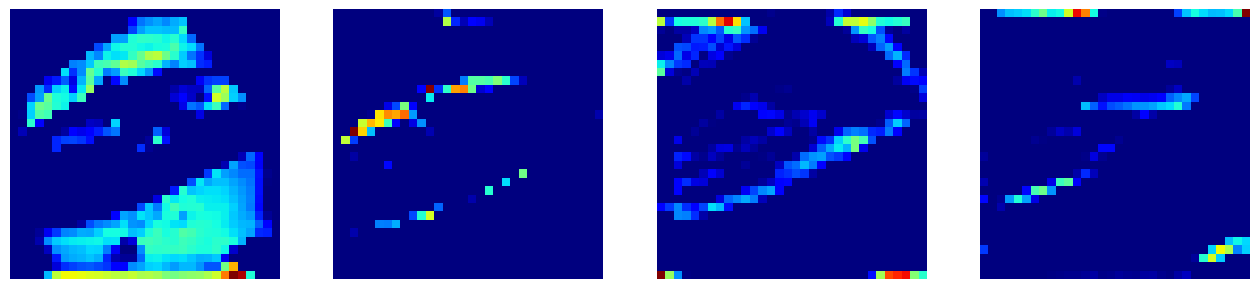

In [37]:
import matplotlib.pyplot as plt

# Choose which layer output you want to visualize
first_layer_activation = activations[2]  # This is the output of the first layer chosen in Step 2

# Let's visualize the first 4 feature maps
plt.figure(figsize=(16, 4))
for i in range(4):  # adjust this to show more or fewer filters
    plt.subplot(1, 4, i + 1)
    plt.imshow(first_layer_activation[0, :, :, i], cmap='jet')
    plt.axis('off')
plt.show()
